# Lesson 6: Essay Writer

In [77]:
from dotenv import load_dotenv

_ = load_dotenv()

In [78]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

import sqlite3
conn = sqlite3.connect("checkpoints_essay.sqlite", check_same_thread=False)
memory = SqliteSaver(conn=conn)

In [79]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [ ]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini")

In [81]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [82]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [83]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [84]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [85]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [86]:
# from langchain_core.pydantic_v1 import BaseModel
from pydantic import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [87]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [88]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [89]:

# Use tavily to search for content based on the queries generated by the research plan node
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        print(f"Search results for query '{q}': {response['results']}")
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [90]:
# Essay writer node that generates a draft based on the plan and content
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [91]:
# Teacher assistant that critiques the draft and provides feedback
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [92]:
# Research critique node that searches for additional information based on the critique
# and updates the content with relevant findings
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [93]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [94]:
builder = StateGraph(AgentState)

In [95]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [96]:
builder.set_entry_point("planner")

In [97]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [98]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [99]:
graph = builder.compile(checkpointer=memory)

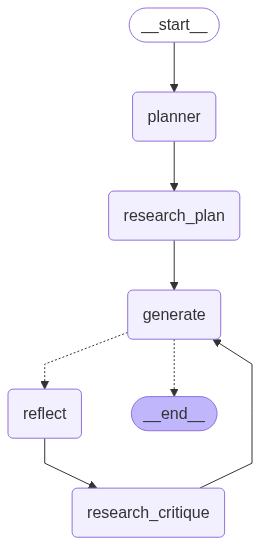

In [100]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [102]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 3,
    "revision_number": 0,
    "content": [],
}, thread):
    print(s)

{'planner': {'plan': 'Title suggestion\n- “LangChain vs. LangSmith: What They Are, How They Differ, and When to Use Each”\n\nThesis (one-sentence)\n- LangChain is a developer framework of composable building blocks for creating LLM-powered applications; LangSmith is a complementary observability/evaluation platform (and associated tooling) that helps you test, trace, debug, and monitor those applications — so one is for building and the other is for operating and improving.\n\nTarget audience & tone\n- Audience: engineers, technical product managers, ML/AI practitioners evaluating tooling for LLM apps.\n- Tone: clear, technical but accessible, pragmatic. Use concrete examples and short code snippets only if needed.\n\nSuggested total length\n- 1,200–1,800 words (adjust per publication). Provide diagrams/tables for quick comparison.\n\nOutline with notes/instructions\n\n1. Introduction (100–150 words)\n   - Purpose: explain why comparing these two tools matters (rise of LLM apps; need f

## Essay Writer Interface

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

# from helper import ewriter, writer_gui

In [ ]:
# MultiAgent = ewriter()
# app = writer_gui(MultiAgent.graph)
# app.launch()